<a href="https://colab.research.google.com/github/tommasoboccali/ml_infn_hackBase/blob/main/CNN_Rizzi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tutorial on CNN
We try to build a DNN that recognize if an image contains a rectangle or a circle

## Import useful stuff

In [ ]:
from keras.layers import Input,Dense,Dropout,Conv2D,MaxPooling2D,Flatten
from keras.models import Model
import numpy as np
from math import *
from matplotlib import pyplot as plt 
import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#print(device_name)

## Lets generate some data

We now generate ourself some images with a circle or a rectangle, of random color, in a random position.

Three different modes of generating the images are implemented:

*   A single shape per figure
*   Multiple shapes mixed in each figure
*   A single figure keeping track of the "bounding box"



### Additional Exercise
1. Try adding some random noise in the image background
2. Try adding more classes such e.g. Lines or Ellipses


In [ ]:
import cv2

addnoise=False
simple =True #single shape per figure
mixed  =False #multi shapes per figure
withBB =False  #one shape with bounding boxes


def background():
  #here one can add noise
  if addnoise:
    return np.array(np.random.rand(64,64,3)*20+100,np.uint8)
  else :
    return np.zeros((64,64,3), np.uint8)

def randomColor():
  return (int(np.random.rand()*128+128),int(np.random.rand()*128+128),int(np.random.rand()*128+128))

def drawCircle(c,x,y,r):
  img = background()
  cv2.circle(img,(x,y),r,c, -1)
  return img,x-r,y-r,x+r,y+r#return image and bounding box

def genCircle():
  return drawCircle(randomColor(),int(np.random.rand()*50)+10,int(np.random.rand()*50)+10,
                    int(np.random.rand()*6)+3)

def drawRectangle(c,x,y,w,h):
  img = background()
  cv2.rectangle(img,(x,y),((x+w),(y+h)), c, -1)
  return img,x,y,x+w,y+h #return image and bounding box

def genRectangle():
  return drawRectangle(randomColor(),int(np.random.rand()*40)+10,int(np.random.rand()*40)+10,
                       int(np.random.rand()*12)+5,int(np.random.rand()*12)+5)

def genN(f,i):
  img = np.zeros((64,64,3), np.uint8)
  for x in range(i):
    img+=f()[0] #discard bb info, take only image
  return img

nsamples=1000

#produce figures with either a rectangle or a circle
if simple :
  targets=np.random.rand(nsamples) > 0.5  
  images=np.array([genCircle()[0] if targets[x] else genRectangle()[0] for x in range(nsamples)])


if mixed:
#produce figure with n rectangles and m circles
  targets=np.array([(int(np.random.rand()*4),int(np.random.rand()*4)) for x in range(nsamples) ])
  images=np.array([genN(genRectangle,targets[x,0])+genN(genCircle,targets[x,1]) for x in range(nsamples)])

if withBB : 
#produce figures with either a rectangle or a circle
  targets=np.array([np.random.rand()>0.5 for x in range(nsamples) ])
  imagesWithBB=[genCircle() if targets[x] else genRectangle() for x in range(nsamples)]
  images=np.array([imagesWithBB[x][0] for x in range(nsamples)])
  boundingBoxes=np.array([imagesWithBB[x][1:] for x in range(nsamples)])







Let's show a few of the generated images

(1000,)
(1000, 64, 64, 3)
[ True  True]


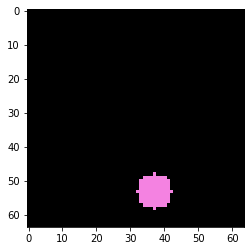

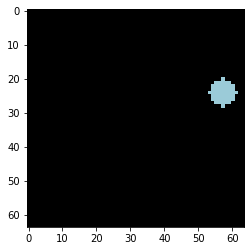

In [ ]:
print(targets.shape)
print(images.shape)
#print(targets)
print(targets[:2])
plt.imshow(images[0])
plt.show()
plt.imshow(images[1])

if withBB:
  print(boundingBoxes.shape)
  print(boundingBoxes[:2])


We concatenate zeroes and ones as labels and the shuffle with the same permutation both the data and the labels.
## Exercise
3. If we have more categories (let say N) we should use a categorical label that is a vector of length N with 1 on the category(/ies) the image belong to and 0 in the others. Try to build a categorical label for two categories (e.g. using numpy "tile" function to repeat the same raw multiple times )
4. Expand the categorical label to  Ellispes or  Lines  and possibly also non exclusive categories such has 2D vs 1D objects

In [ ]:
if withBB :
    labels=[targets,boundingBoxes] 
else:
    labels=targets

data=images


# Let's build a CNN 

Now we build our first CNN. We have some Conv layers interleaved with MaxPooling

Finally we flatten the output of the convolutional stack and appply a Dense FF

### MaxPooling
![alt text](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)

### Exercise
5. Try adding/removing convolutional layers, change the kernel size, try to add dropout
6. Try changing the model to categorical labels, change loss function from binary_crossentropy to categorical_crossentropy, and use softmax activation instead of sigmoid


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 60, 5)         380       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 3)         138       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 3)           0         
_________________________________________________________________
flatten (Flatten)            (None, 108)               0         
_________________________________________________________________
dense (Dense)                (None, 30)                3270  

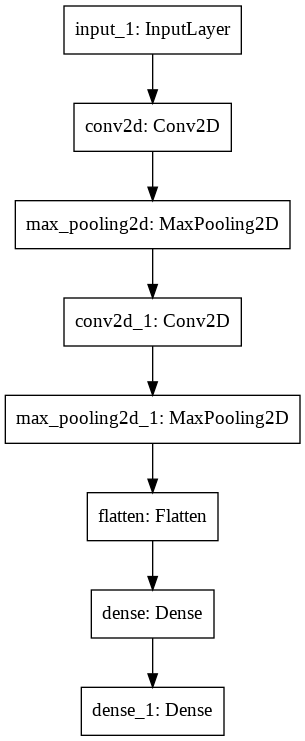

In [ ]:
inputs=Input(shape=(64,64,3,))
hidden=  Conv2D(5,(5,5), activation='relu')(inputs)
hidden= MaxPooling2D((3,3))(hidden)
hidden=  Conv2D(3,(3,3), activation='relu')(hidden)
hidden= MaxPooling2D((3,3))(hidden)
#hidden=  Conv2D(3,(3,3), activation='relu')(hidden)
hidden= Flatten()(hidden)
#hidden=  Dense(50, activation='relu')(hidden)
#hidden=  Dense(40, activation='relu')(hidden)
hidden=  Dense(30, activation='relu')(hidden)
if simple : 
  outputs = Dense(1, activation='sigmoid')(hidden)
  loss="binary_crossentropy"
if mixed : 
  outputs = Dense(2, activation='relu')(hidden)
  loss='MSE'
if withBB : 
  output1 = Dense(1, activation='sigmoid')(hidden)
  output2 = Dense(4, activation='linear')(hidden)
  outputs=[output1,output2]
  loss=["binary_crossentropy","MSE"]
  
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss=loss, optimizer='adam',metrics=['accuracy'])

model.summary()
from keras.utils import plot_model

plot_model(model, to_file='model.png')

And now let's fit it to our data.
The sample is automatically split in two so that 50% of it is used for validation and the other half for training


In [ ]:
history=model.fit(data,labels,validation_split=0.5,epochs=20)

Epoch 1/20
16/16 [==============================] - 33s 39ms/step - loss: 5.0422 - accuracy: 0.5303 - val_loss: 2.9082 - val_accuracy: 0.5300
Epoch 2/20
16/16 [==============================] - 0s 8ms/step - loss: 2.3119 - accuracy: 0.5826 - val_loss: 2.0055 - val_accuracy: 0.5240
Epoch 3/20
16/16 [==============================] - 0s 8ms/step - loss: 1.2710 - accuracy: 0.6426 - val_loss: 1.6520 - val_accuracy: 0.5520
Epoch 4/20
16/16 [==============================] - 0s 8ms/step - loss: 0.9898 - accuracy: 0.7036 - val_loss: 1.5088 - val_accuracy: 0.5840
Epoch 5/20
16/16 [==============================] - 0s 8ms/step - loss: 0.7438 - accuracy: 0.7295 - val_loss: 1.4925 - val_accuracy: 0.5840
Epoch 6/20
16/16 [==============================] - 0s 8ms/step - loss: 0.7201 - accuracy: 0.7542 - val_loss: 1.3371 - val_accuracy: 0.6020
Epoch 7/20
16/16 [==============================] - 0s 7ms/step - loss: 0.4845 - accuracy: 0.8294 - val_loss: 1.2624 - val_accuracy: 0.6100
Epoch 8/20
16/16 [

*history* contains information about the training.  We can now now show the loss vs epoch for both validation and training samples.




dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


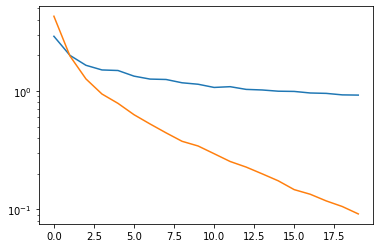

In [ ]:
print(history.history.keys())
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.yscale('log')
plt.show()
#plt.plot(history.history["val_accuracy"])
#plt.plot(history.history["accuracy"])
#plt.show()


In [ ]:
print(model.predict(np.expand_dims(genRectangle()[0],axis=0) ))
print(model.predict(np.expand_dims(genCircle()[0],axis=0) ))


[[0.00027483]]
[[0.99535865]]


Let's try to mix an image with circles and rectangles and see how the network would evaluate it 

In [ ]:
if mixed :
  im= genCircle()[0]+genRectangle()[0]+genRectangle()[0]
  #print("Looks like a", ("circle" if model.predict(np.expand_dims(im,axis=0) )[0,1] > 0.5 else "rectangle"))
  print("There are ", model.predict(np.expand_dims(im,axis=0) )[0])
  plt.imshow(im)
  plt.show()

if withBB:
  im,x1,y1,x2,y2= genCircle()
  pre=model.predict(np.expand_dims(im,axis=0) )
  isCircle=pre[0][0]
  x1p=pre[1][0][0]-1.
  y1p=pre[1][0][1]-1.
  x2p=pre[1][0][2]+1.
  y2p=pre[1][0][3]+1.
  print(x1p,y1p,x2p,y2p)
  #print("Looks like a", ("circle" if model.predict(np.expand_dims(im,axis=0) )[0,1] > 0.5 else "rectangle"))
  print("It is a","circle" if isCircle > 0.5 else "rectangle" )
  cv2.rectangle(im,(x1-1,y1-1),(x2+1,y2+1), (255,0,0), 1)
  cv2.rectangle(im,(int(x1p),int(y1p)),(int(x2p),int(y2p)), (255,255,0), 1)
  plt.imshow(im)
  plt.show()


The following code can be used to visualize what features the first conv layer is looking at

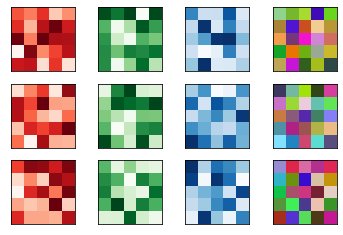

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix =3, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 4, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap=['Reds','Greens','Blues'][j])
		ix += 1
	ax = plt.subplot(n_filters, 4, ix)
	ax.set_xticks([])
	ax.set_yticks([])
	plt.imshow(f)
	ix += 1


# show the figure
plt.show()